In [1]:
# Packages
using JuMP
using HiGHS
using CSV
using DataFrames
using Plots
using StatsPlots
using Printf

In [2]:
# include the helper functions
include("functions-to-import-data.jl");
include("functions-to-export-data.jl");
include("functions-to-plot-results.jl");

In [3]:
# include the file with the functions for the stochastic GEP model
include("Adaptive-robust-optimization-GEP.jl");

In [4]:
# Folders names
input_folder = joinpath(@__DIR__, "inputs/aro");
output_folder = joinpath(@__DIR__, "outputs/aro");

In [5]:
# read the data
sets, params = read_aro_data(input_folder);

In [6]:
first_stage_model = create_first_stage_model(sets, params)

A JuMP Model
Minimization problem with:
Variables: 5
Objective function type: AffExpr
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 5 constraints
`VariableRef`-in-`MathOptInterface.Integer`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: v_investment, v_theta

In [7]:
# Benders decomposition algorithm

# Define constants
MAXIMUM_ITERATIONS = 100       # maximum number of iterations
ABSOLUTE_OPTIMALITY_GAP = 1e-6 # gap between lower and upper bounds to stop the algorithm

# Define outputs
df_Benders_interations = DataFrame(;
    iteration=Int[],
    lower_bound=Float64[],
    upper_bound=Float64[],
    gap=Float64[],
)

df_investment_per_iteration =
    DataFrame(; iteration=Int[], generator=String[], investment=Float64[])

# Start Benders' Decomposition
upper_bound = Inf
println("Iteration  Lower Bound  Upper Bound          Gap")
for iteration in 1:MAXIMUM_ITERATIONS
    optimize!(first_stage_model)
    @assert is_solved_and_feasible(first_stage_model)
    lower_bound = objective_value(first_stage_model)
    p_investment = value.(first_stage_model[:v_investment])
    subproblem = create_and_solve_subproblem(sets, params, p_investment)
    upper_bound = minimum([upper_bound,
        objective_value(first_stage_model) - value.(first_stage_model[:v_theta]) + objective_value(subproblem)
    ])
    gap = (upper_bound - lower_bound) / upper_bound
    push!(df_Benders_interations, (iteration, lower_bound, upper_bound, gap))
    print_iteration(iteration, lower_bound, upper_bound, gap)

    if gap < ABSOLUTE_OPTIMALITY_GAP
        println("Terminating with the optimal solution")
        break
    end
    add_cut(first_stage_model, subproblem, sets, params, iteration)

    for g in sets[:G]
        push!(df_investment_per_iteration, (iteration, g, p_investment[g]))
    end
end

Iteration  Lower Bound  Upper Bound          Gap
        1  -1.0000e+03   1.5030e+06   1.0007e+00
        2   1.1368e+05   1.3296e+06   9.1450e-01
        3   3.8342e+05   1.0208e+06   6.2440e-01
        4   4.5983e+05   9.6990e+05   5.2590e-01
        5   4.8874e+05   9.6990e+05   4.9610e-01
        6   4.9700e+05   4.9700e+05  -9.4865e-15
Terminating with the optimal solution


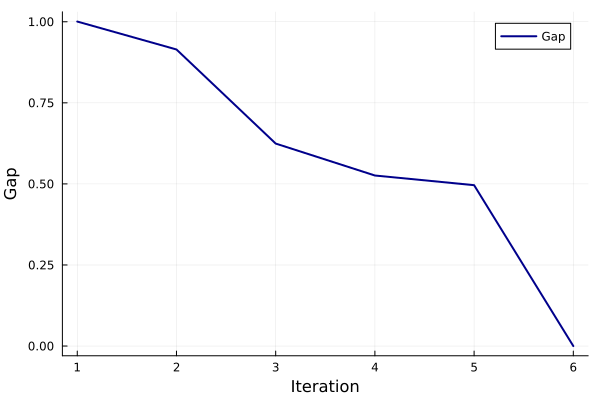

In [8]:
#plotly()
plot_gap(df_Benders_interations)

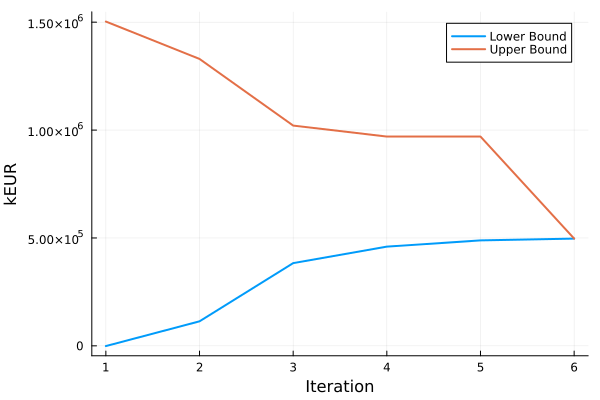

In [9]:
plot_bounds(df_Benders_interations)

In [10]:
optimize!(first_stage_model)
@assert is_solved_and_feasible(first_stage_model)
v_investment_optimal = value.(first_stage_model[:v_investment])

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, String7["ocgt", "ccgt", "wind", "solar"]
And data, a 4-element Vector{Float64}:
  10.0
   2.0
  16.0
 159.0

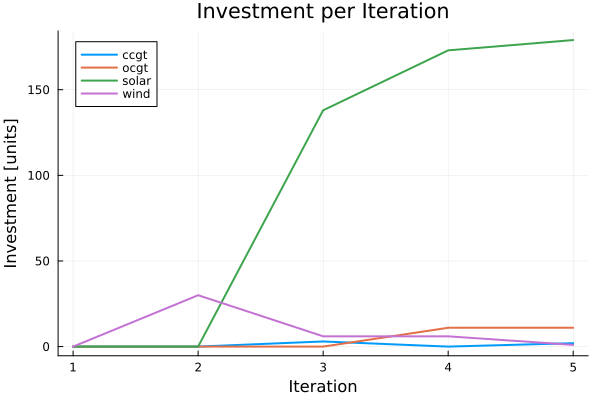

In [11]:
plot_investment_per_iteration(df_investment_per_iteration)

In [12]:
subproblem = create_and_solve_subproblem(sets, params, v_investment_optimal)

A JuMP Model
Maximization problem with:
Variables: 748
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 168 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 865 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 436 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 52 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 288 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: c_balance, c_csc_max_ens_a, c_csc_max_ens_b, c_csc_max_exc_a, c_csc_max_exc_b, c_csc_max_prod_a, c_csc_max_prod_b, c_csc_min_ens_a, c_csc_min_ens_b, c_csc_min_exc_a, c_csc_min_exc_b, c_csc_min_prod_a, c_csc_min_prod_b, c_dual_ens, c_dual_exc, c_dual_prod, c_max_ens, c_max_exc, c_max_prod, c_min_ens, c_min_exc, c_min_prod, c_uncertainty_budget, v_avai, v_csc_max_ens, v_csc_max_exc, v_csc_max_prod, v_csc_min_ens, v_csc_min_exc, v_csc_min_prod, v_dual_balanc

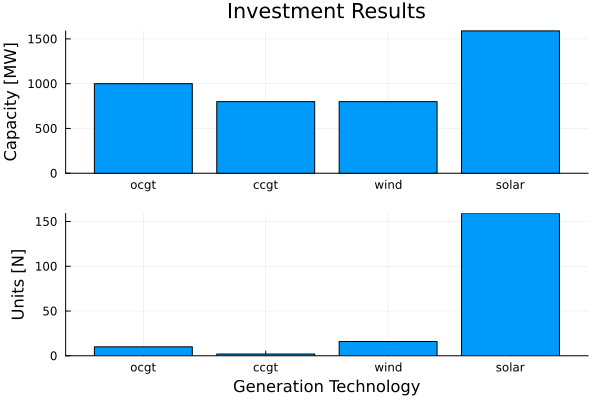

In [13]:
plot_two_stage_investment(first_stage_model, sets, params)

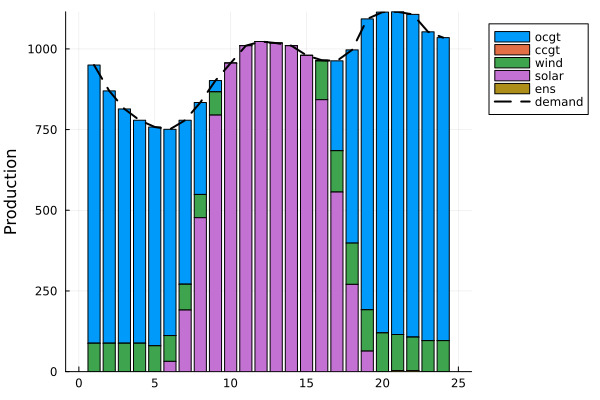

In [14]:
plot_aro_production(subproblem, params)

In [15]:
save_results_benders_first_stage_to_csv(output_folder, first_stage_model)